<a href="https://colab.research.google.com/github/GianfrancoIngratta/AlexNet_Pokedex/blob/main/myPokedex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pokemon Images classification using AlexNet-based CNN architecture**

In this notebook is present the core of the image analysis performed by the AlexNet. 
 
 

In [1]:
!pip install opendatasets
!pip install import_ipynb
import import_ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time 

from os import listdir
import os
import cv2 as cv
import glob
import opendatasets as od

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torch.optim import lr_scheduler 
from torchvision import transforms, utils
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.io import read_image
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from skimage import io, transform
import torch.optim as optim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.7 MB/s 


## **Preliminary setup**
In order to run the notebook in colab, it is necessary to mount your drive repository, which should include all the notebooks needed and the dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#%cd /content/drive/MyDrive/Colab_Notebooks/project_exam/AlexNet_Pokedex/  #gianfranco's path
%cd /content/drive/My Drive/myPokedex/AlexNet_Pokedex                      #giacomo's path

/content/drive/My Drive/myPokedex/AlexNet_Pokedex


Now it is possible to include the notebooks `AlexNet.ipynb`, `image_tools.ipynb` and it is possible to download the dataset from Kaggle (an account to do that is needed).




In [5]:
import  sys
#sys.path.append('/content/drive/MyDrive/Colab_Notebooks/project_exam/AlexNet_Pokedex/')
sys.path.append('/content/drive/My Drive/myPokedex/AlexNet_Pokedex')
from tools.AlexNet import AlexNet
from tools.images_tools import *

importing Jupyter notebook from /content/drive/MyDrive/myPokedex/AlexNet_Pokedex/tools/AlexNet.ipynb
importing Jupyter notebook from /content/drive/MyDrive/myPokedex/AlexNet_Pokedex/tools/images_tools.ipynb


In [6]:
od.download("https://www.kaggle.com/datasets/thedagger/pokemon-generation-one")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: giacomolevrini
Your Kaggle Key: ··········


100%|██████████| 2.15G/2.15G [00:15<00:00, 147MB/s]


An important preliminary set is to build the class `PokemonImageDataset` which will come in hand later on in the training of the network. Basically, this class clusterize the important parameters from the dataset (the image and the image label), but it will not be used to feed directly the newtwork. Instead, it will be used to build another object, which is more efficent in the feeding of the network training (and also another important feature will be explained later on). 

In [12]:
from torch.nn.common_types import Tensor
class PokemonImageDataset(Dataset):
  """ Pokemon images dataset """
  
  def __init__(self, list_of_pokemon_images, images_labels, transform = None):
    """
    Args:
        list_of_pokemon_images    list[string]: list of pokemon file path
        images_labels             list[string]: list of pokemon labels for each image
        transform                 (callable, optional): Optional transform to be applied on a semple
    """
    self.list_of_pokemon_images = list_of_pokemon_images
    self.images_labels          = images_labels
    self.transform              = transform

  def __len__(self):
    " returns the number of samples (images) in our dataset. "
    return len(self.list_of_pokemon_images)
  
  def __getitem__(self, idx : int) -> dict:
    """
    The __getitem__ function loads and returns a sample from the dataset at the given index idx. 
    Based on the index, it identifies the image’s location on disk, converts that to a tensor using read_image, 
    retrieves the corresponding label, 
    calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a dictionary.
    """
    if torch.is_tensor(idx): idx = idx.tolist()
    
    try: 
      image = read_image(self.list_of_pokemon_images[idx])
      label = self.images_labels[idx]
    except:
      image = read_image(self.list_of_pokemon_images[0])
      # print(f"image type {image.dtype}")
      label = self.images_labels[0]

    nof_channels = image.shape[0]

    if(nof_channels == 4): #deal with 4 channels -> cut 1 channel
      image = image[:3,:]
    elif(nof_channels == 1): #deal with 1  channels -> extend to 3 channels (2 redundant)
      image = image.expand(3,*image.shape[1:])


    sample = {"image":image, "label":label}
    
    if self.transform:
      sample = self.transform(sample)
    return sample




From the `pwd` you are working with, here is possible to select the Pokémon you want to run the training. In here, the objects needed to build the class previously defined are extracted from the dataset and used to build the `pokemon_dataset` on which the network will work one.

In [14]:
#root_path = '/content/drive/MyDrive/Colab_Notebooks/project_exam/AlexNet_Pokedex/pokemon-generation-one/dataset/'
root_path = '/content/drive/My Drive/myPokedex/AlexNet_Pokedex/pokemon-generation-one/dataset/'

list_of_pokemons=['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']

numerical_label = dict(zip(list_of_pokemons,range(len(list_of_pokemons))))

list_of_images = [file for pokemon in list_of_pokemons for file in glob.glob(root_path + pokemon + "/*")]

list_of_labels = []

for image_path in list_of_images:
  for name, label in numerical_label.items():
    if name in image_path: list_of_labels.append(numerical_label[name])

In [15]:
print(f"example: image -> {list_of_images[0]}, label -> {list_of_labels[0]}")
print(f"example: image -> {list_of_images[1000]}, label -> {list_of_labels[1000]}")
print(f"number of images : {len(list_of_images)}, number of labels : {len(list_of_labels)}")

example: image -> /content/drive/My Drive/myPokedex/AlexNet_Pokedex/pokemon-generation-one/dataset/Mewtwo/00000000.jpg, label -> 0
example: image -> /content/drive/My Drive/myPokedex/AlexNet_Pokedex/pokemon-generation-one/dataset/Bulbasaur/00000104.png, label -> 3
number of images : 1470, number of labels : 1470


In [18]:
pokemon_dataset = PokemonImageDataset(list_of_images, list_of_labels)

Now, to see which images have been picked, this lines make the job. Of course, those images have to be adapted to become input of the cNN.

sample :  0 torch.Size([3, 1000, 1000])
sample :  1 torch.Size([3, 1200, 1600])
sample :  2 torch.Size([3, 1200, 1600])
sample :  3 torch.Size([3, 1500, 1500])


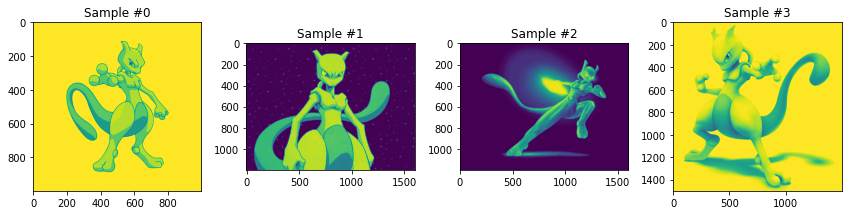

In [19]:
fig,ax = plt.subplots(1,4,figsize=(12,8))

for i, sample in enumerate(pokemon_dataset):
  print("sample : ", i, sample['image'].shape)
  plt.tight_layout()
  ax[i].set_title('Sample #{}'.format(i))
  # ax[i].axis('off')
  
  try:
    ax[i].imshow(sample["image"])
  except:
    ax[i].imshow(sample["image"][0])
    # print("4 images resized to 3 k")
  if i==3: break

## **Image uniformation and Dataloaders**

Using the classes included from the notebook `image_tools.ipynb`, we can build a rescaler and a cropper to uniform all the images. In particular, are combined to optimize either the dimension and the zoom to better "centre" the Pokémons. 

In [20]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

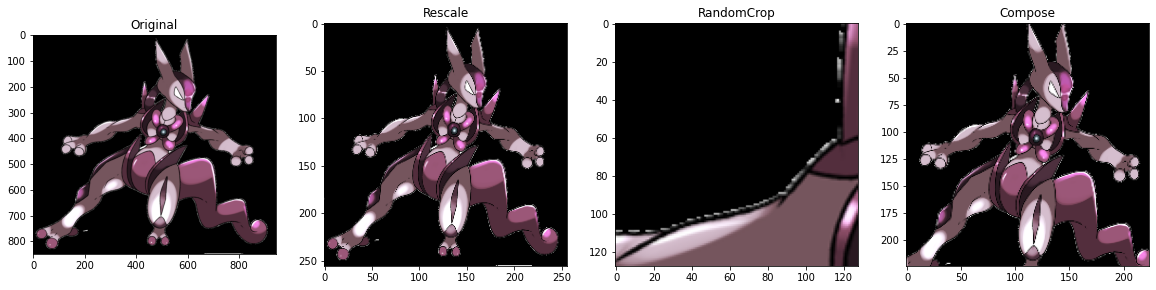

In [21]:
fig,ax = plt.subplots(1,4,figsize=(20,10))

sample = pokemon_dataset[38] # what if image has 4k resolution ?

ax[0].imshow(sample["image"].transpose(0,1).transpose(1,2))
ax[0].set_title("Original")

for i, tsfrm in enumerate([scale, crop, composed]):  
  transformed_sample = tsfrm(sample)
  # if(i==2):
  #     mean = (transformed_sample["image"].float()[0].mean(), transformed_sample["image"].float()[1].mean(), transformed_sample["image"].float()[2].mean())
  #     std  = (transformed_sample["image"].float()[0].std(),  transformed_sample["image"].float()[1].std(),  transformed_sample["image"].float()[2].std())
  #     norm = Normalize(mean, std)
  #     transformed_sample = norm(transformed_sample)

  ax[i+1].set_title(type(tsfrm).__name__)
  ax[i+1].imshow(transformed_sample["image"].transpose(0,1).transpose(1,2))


A very powerfull characteristic of the class `PokemonImageDataset` is that it can take as argument a given transformation that have to be applied to all the images of the dataset: this allow to directly create a dataset with well-shaped images. 

Now, the dataset can be feed to the so called **dataloader**, an optimized object which duplicates the input dataset incoming, allowing to iterate upon the full dataset provided with a sampler. 

In [22]:
pokemon_dataset = PokemonImageDataset(list_of_pokemon_images = list_of_images, 
                                      images_labels          = list_of_labels,
                                      transform              = transforms.Compose([Rescale(256),
                                                                                   RandomCrop(224)]
                                                                                  ))

pokemon_dataloader = DataLoader(pokemon_dataset, batch_size = 4, shuffle = True, num_workers=0)

This allows to easily exrtact images and their labels.

batch number : 0, batch shape : torch.Size([4, 3, 224, 224]), batch[0] shapetorch.Size([3, 224, 224]), label tensor([0, 0, 1, 4])
batch number : 1, batch shape : torch.Size([4, 3, 224, 224]), batch[0] shapetorch.Size([3, 224, 224]), label tensor([4, 0, 2, 2])
batch number : 2, batch shape : torch.Size([4, 3, 224, 224]), batch[0] shapetorch.Size([3, 224, 224]), label tensor([3, 0, 4, 4])
batch number : 3, batch shape : torch.Size([4, 3, 224, 224]), batch[0] shapetorch.Size([3, 224, 224]), label tensor([3, 3, 2, 1])


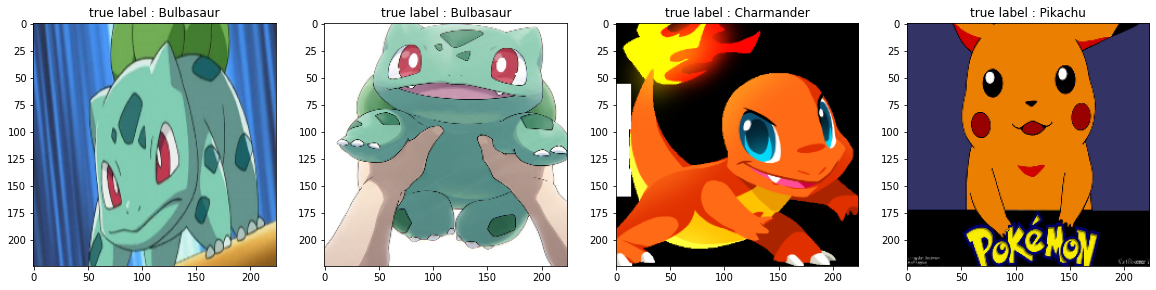

In [23]:
for i_batch, sample_batched in enumerate(pokemon_dataloader):
  image = sample_batched["image"]
  label = sample_batched["label"]
  print(f"batch number : {i_batch}, batch shape : {image.size()}, batch[0] shape{image[0].size()}, label {label}")
  
  if i_batch == 3:
    images_batch, label_batch = sample_batched['image'],sample_batched['label']
    batch_len = images_batch.shape[0]
    fig,ax = plt.subplots(1,batch_len, figsize = (20,10))
    for i in range(batch_len):
      ax[i].imshow(images_batch[i].permute(1,2,0))
      ax[i].set_title(f"true label : {list_of_pokemons[label_batch[i]]}")
    break

## **Train, validation and test split**

It is now possible to divide the dataset into train and test sets, and subsequently divide the train into real train and validation sets. 

In [24]:
train, test_set = train_test_split(pokemon_dataset, test_size=0.2, train_size = 0.8, random_state = 42,shuffle=True)

In [25]:
train_set, validation_set =  train_test_split(train, test_size=0.25, train_size = 0.75, random_state = 42,shuffle=True)

In [26]:
print("training set size : {}, validation set size : {}, test set size : {}".format(len(train_set),len(validation_set),len(test_set)))

training set size : 882, validation set size : 294, test set size : 294


Once the sizes of the sets are check, new dataloaders are build per each new set, ready to be fed to the network.

In [27]:
dataloaders = {'train': DataLoader(train_set, batch_size = 10, shuffle = True, num_workers=0), 
               'val'  : DataLoader(validation_set, batch_size = 10, shuffle = True, num_workers=0), 
               'test' : DataLoader(test_set, batch_size = 10, shuffle = True, num_workers=0)} 

dataset_sizes = {x: y for x,y in zip(['train', 'val','test'],[len(train_set),len(validation_set),len(test_set)])}

In [28]:
print(dataset_sizes["val"])

294


In [29]:
for dictionary in dataloaders['train']:
  print(dictionary['image'].shape)
  if i == 3: break

torch.Size([10, 3, 224, 224])


## **Training of the Network**

Eventually, the model can be built from, from the class in `AlexNet.ipynb`, and after setting all the needed parameters, it can be trained (beware, to run an epoch takes likely 3 minutes).



In [30]:
model = AlexNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [32]:
num_epochs = 20

since = time.time()
best_accuracy = 0.

train_accuracy, validation_accuracy, train_loss,  validation_loss = ([] for i in range(4))

for epoch in range(num_epochs):
  print(f'Epoch {epoch}/{num_epochs - 1}')
  print('-'*10)

  for phase in ['train','val']:
    if phase == 'train':
      model.train() # set model to training mode
    else:
      model.eval()   # set model to evaluate mode (tested on the validation set first)

    running_loss, running_corrects = 0.0, 0

    for running_data in dataloaders[phase]:
      images = running_data['image']
      labels = running_data['label']

      # zero the parameter gradients
      optimizer.zero_grad()
      # print("setting zero gradients")

      # forward
      # track history if only in train

      with torch.set_grad_enabled(phase == 'train'):
        # print("Alla fine l'input gli è piaciuto")
        outputs = model(images.float())
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

      # backward + optimize only if in training phase
        if phase == 'train':
          loss.backward()
          optimizer.step()

      running_loss += loss.item() * images.size(0)
      running_corrects += torch.sum(preds == labels.data)
    # (Da rivedere) call of the progress step per epoch
    if phase == 'train': 
      scheduler.step()
    
    #loss and accuracy evaluation per each epoch
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_accuracy = running_corrects.double() / dataset_sizes[phase]

    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')
    if phase == 'train':
      train_accuracy.append(epoch_accuracy)
      train_loss.append(epoch_loss)
    if phase == 'val':
      validation_accuracy.append(epoch_accuracy)
      validation_loss.append(epoch_loss)
      
    if phase == 'val' and epoch_accuracy > best_accuracy:
      best_accuracy = epoch_accuracy
      # best_model_wts = copy.deepcopy(model.state_dict())
    
    print()

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_accuracy:4f}')

# load best model weights
# model.load_state_dict(best_model_wts)





Epoch 0/19
----------
train Loss: 1.3672 Acc: 0.5408

val Loss: 1.7528 Acc: 0.5204

Epoch 1/19
----------
train Loss: 0.8004 Acc: 0.7256

val Loss: 0.5185 Acc: 0.8469

Epoch 2/19
----------
train Loss: 0.7156 Acc: 0.7630

val Loss: 0.4669 Acc: 0.8571

Epoch 3/19
----------
train Loss: 0.6484 Acc: 0.7993

val Loss: 0.7832 Acc: 0.7585

Epoch 4/19
----------
train Loss: 0.6304 Acc: 0.7732

val Loss: 0.6949 Acc: 0.7891

Epoch 5/19
----------
train Loss: 0.5867 Acc: 0.8073

val Loss: 0.6226 Acc: 0.8333

Epoch 6/19
----------
train Loss: 0.5935 Acc: 0.8186

val Loss: 0.5642 Acc: 0.8469

Epoch 7/19
----------
train Loss: 0.4362 Acc: 0.8458

val Loss: 0.3933 Acc: 0.8946

Epoch 8/19
----------
train Loss: 0.3875 Acc: 0.8571

val Loss: 0.4134 Acc: 0.8673

Epoch 9/19
----------
train Loss: 0.3715 Acc: 0.8810

val Loss: 0.4123 Acc: 0.8980

Epoch 10/19
----------
train Loss: 0.3390 Acc: 0.8810

val Loss: 0.3719 Acc: 0.9082

Epoch 11/19
----------
train Loss: 0.3028 Acc: 0.8866

val Loss: 0.3807 Acc

## **Model evalutation**

Now the network is trained, and it is time to see how good it predicts the Pokémon in the test set.

294 294


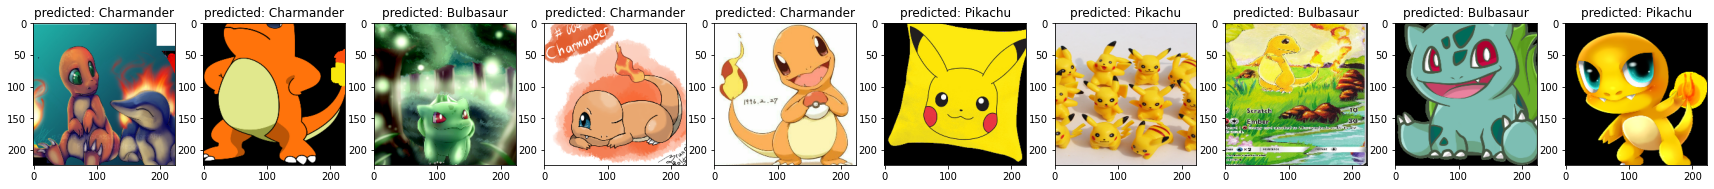

In [34]:
model.eval()
was_training = model.training

predicted_label, true_label = [],[]
print_images = 1
with torch.no_grad():
  for running_data in dataloaders['test']:
    images = running_data['image']
    labels = running_data['label']

    outputs = model(images.float())
    _, preds = torch.max(outputs, 1)

    predicted_label.append(preds)
    true_label.append(labels.data)

    if print_images == 1:
      fig,ax = plt.subplots(1,10, figsize=(30,15))
      for index,images in enumerate(images):
        ax[index].imshow(images.permute(1,2,0))
        ax[index].set_title(f"predicted: {list_of_pokemons[preds[index]]}")
    
    print_images = 0;


predicted_label = np.concatenate([i for i in predicted_label])
true_label = np.concatenate([i for i in true_label])
print(len(predicted_label),len(true_label))

### **Accuracy and Loss of the model**

The behaviour of the accuracies and losses is shown in the following plots. Apparently, even with large epochs, the accuracy never exceeds the 90%, while the losses are in the range of 30%-40%.


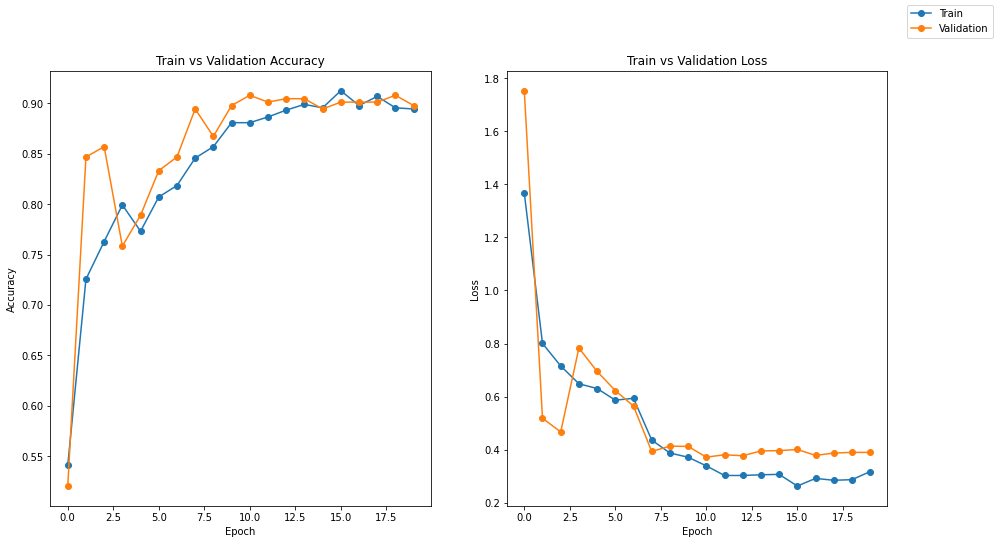

In [33]:
fig,ax = plt.subplots(1,2,figsize=(15,8))

ax[0].plot(train_accuracy,'-o')
ax[0].plot(validation_accuracy,'-o')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
# ax[0].set_legend(['Train','Validation'])
ax[0].set_title('Train vs Validation Accuracy')

ax[1].plot(train_loss,'-o')
ax[1].plot(validation_loss,'-o')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Train vs Validation Loss')

fig.legend(['Train','Validation'])


## **Confusion Matrix**

The confusion matrix allows to see which labels were mismatched: one possible reason for that is that some images have wrong RGB colours or multiple Pokémons appears in a single image. Improvements can be done on the dataset by discarding those images, but apart from that the result are quite encouraging. 

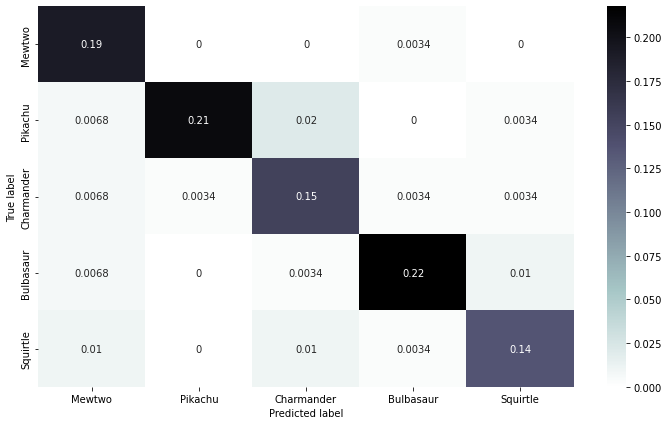

In [35]:
from sklearn.metrics import confusion_matrix

# Build confusion matrix
cf_matrix = confusion_matrix(true_label, predicted_label)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in list_of_pokemons],
                     columns = [i for i in list_of_pokemons])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, cmap="bone_r")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [ ]:
cf_matrix

array([[55,  0,  0,  2,  0],
       [ 3, 41, 10, 12,  4],
       [ 2,  2, 43,  2,  1],
       [ 1,  0,  1, 63,  5],
       [12,  0,  1,  1, 33]])

In [ ]:
np.sum(cf_matrix/np.sum(cf_matrix))

1.0